# Training a neural network model on the Reuters dataset

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---

## Load the data

In [2]:
root_dir = '../../'
src_dir = 'src'
data_dir = 'data/corpus'
models_dir = 'data/models'

In [3]:
import os
import sys

In [4]:
sys.path.append(os.path.join(root_dir, src_dir))

In [5]:
corpus_filename = 'reuters_corpus.json'

In [6]:
from training import TrainingCorpus

In [7]:
reuters_corpus = TrainingCorpus()
reuters_corpus.load(os.path.join(root_dir, data_dir, corpus_filename))

In [8]:
reuters_corpus.size

9848

---

## Load the Glove model

In [9]:
from gensim.models import KeyedVectors

unable to import 'smart_open.gcs', disabling that module


In [10]:
glove_filename = 'glove.6B.200d.word2vec'

In [11]:
glove_model = KeyedVectors.load_word2vec_format(os.path.join(root_dir, models_dir, glove_filename), binary=False)

---

## Split the dataset into training and test set

In [12]:
train_doc_ids, test_doc_ids, train_labels, test_labels = reuters_corpus.get_train_test_data(test_size=0.2, random_state=3)

In [13]:
n_classes = train_labels.shape[1]
print(f'Training set size: {len(train_doc_ids)}')
print(f'Test set size: {len(test_doc_ids)}')
print(f'No. of labels: {n_classes}')

Training set size: 7878
Test set size: 1970
No. of labels: 20


---

## Build the embedding matrix

### Define the vocabulary

In [14]:
docs_tokens = [reuters_corpus.get_tokens(doc_id) for doc_id in train_doc_ids]
vocab = sorted({token for tokens in docs_tokens for token in tokens})

In [15]:
vocab[:5]

[',100', '-aci', '-agency', '-analysts', '-announced']

In [16]:
print(f'There are {len(vocab)} unique words in the training set')

There are 38016 unique words in the training set


### Encode vocabulary terms as integers

In [17]:
# +1 as index 0 is reserved
word_to_idx_map = {word:idx+1 for idx, word in enumerate(vocab)}

### Define the embedding matrix

In [18]:
import numpy as np

In [19]:
embedding_size = glove_model.vector_size
embedding_size

200

In [20]:
embedding_matrix = np.zeros((len(word_to_idx_map) + 1, embedding_size))
embedding_matrix.shape

(38017, 200)

In [21]:
embedding_found_count = 0

In [22]:
for word, idx in word_to_idx_map.items():
    if word in glove_model:
        # words not found in the embedding matrix will be all-zeros.
        embedding_matrix[idx] = glove_model[word]
        embedding_found_count += 1

In [23]:
print(f'Found embeddings for {embedding_found_count} out of {len(vocab)} words ({round(embedding_found_count/len(vocab)*100,2)}%)')

Found embeddings for 24552 out of 38016 words (64.58%)


---

## Convert documents to sequence of integer indexes

### Define utility functions

In [24]:
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [25]:
def doc_tokens_to_sequence(doc_tokens, word_to_idx_map):
    sequence = []
    
    for token in doc_tokens:
        if token in word_to_idx_map:
            sequence.append(word_to_idx_map[token])

    return sequence

### Encode texts

In [26]:
max_doc_len = max(len(doc_tokens) for doc_tokens in docs_tokens)
max_doc_len

1828

In [27]:
train_doc_sequences = [doc_tokens_to_sequence(reuters_corpus.get_tokens(doc_id), word_to_idx_map) for doc_id in train_doc_ids]
train_padded_sequences = pad_sequences(train_doc_sequences, maxlen=max_doc_len)

## Train the model

### Define the model

In [28]:
from keras import Input
from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.optimizers import Adam

In [29]:
nn_input = Input(shape=(max_doc_len,), dtype='int32')
embedding_output = Embedding(len(word_to_idx_map)+1,
                             embedding_matrix.shape[1],
                             weights=[embedding_matrix],
                             input_length=max_doc_len,
                             trainable=True,
                             mask_zero=True)(nn_input)
lstm = Bidirectional(LSTM(100))(embedding_output)
dense = Dense(64, activation='relu')(lstm)
nn_output = Dense(n_classes, activation='sigmoid')(dense)

nn_model = Model(nn_input, nn_output)

nn_model.compile(loss='binary_crossentropy',
                 optimizer=Adam(),
                 metrics=['accuracy'])

In [30]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

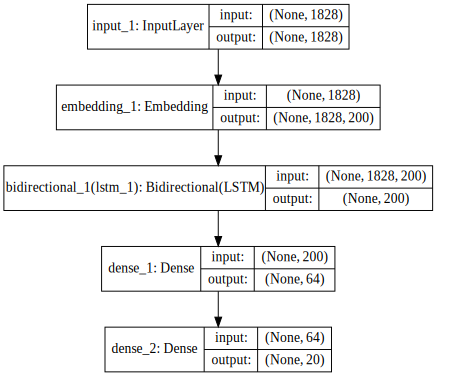

In [31]:
SVG(model_to_dot(nn_model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

### Train the model

In [32]:
import time

In [33]:
start_time = time.time()

history = nn_model.fit(train_padded_sequences, 
                       train_labels, 
                       validation_split=0.1, 
                       epochs=20, 
                       batch_size=200)

elapsed_time = time.time() - start_time
t = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print('Elapsed time (learning):', t)

/home/nvidia/anaconda3/envs/testenv/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 7090 samples, validate on 788 samples
Epoch 1/20
7090/7090 [==============================] - 143s 20ms/step - loss: 0.2775 - accuracy: 0.9121 - val_loss: 0.1526 - val_accuracy: 0.9569
Epoch 2/20
7090/7090 [==============================] - 140s 20ms/step - loss: 0.1170 - accuracy: 0.9660 - val_loss: 0.1023 - val_accuracy: 0.9692
Epoch 3/20
7090/7090 [==============================] - 132s 19ms/step - loss: 0.0829 - accuracy: 0.9737 - val_loss: 0.0801 - val_accuracy: 0.9744
Epoch 4/20
7090/7090 [==============================] - 135s 19ms/step - loss: 0.0642 - accuracy: 0.9786 - val_loss: 0.0663 - val_accuracy: 0.9798
Epoch 5/20
7090/7090 [==============================] - 130s 18ms/step - loss: 0.0516 - accuracy: 0.9827 - val_loss: 0.0596 - val_accuracy: 0.9795
Epoch 6/20
7090/7090 [==============================] - 132s 19ms/step - loss: 0.0428 - accuracy: 0.9855 - val_loss: 0.0500 - val_accuracy: 0.9838
Epoch 7/20
7090/7090 [==============================] - 130s 18ms/step 

### Plot loss and accuracy

In [34]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

In [35]:
import matplotlib.pyplot as plt

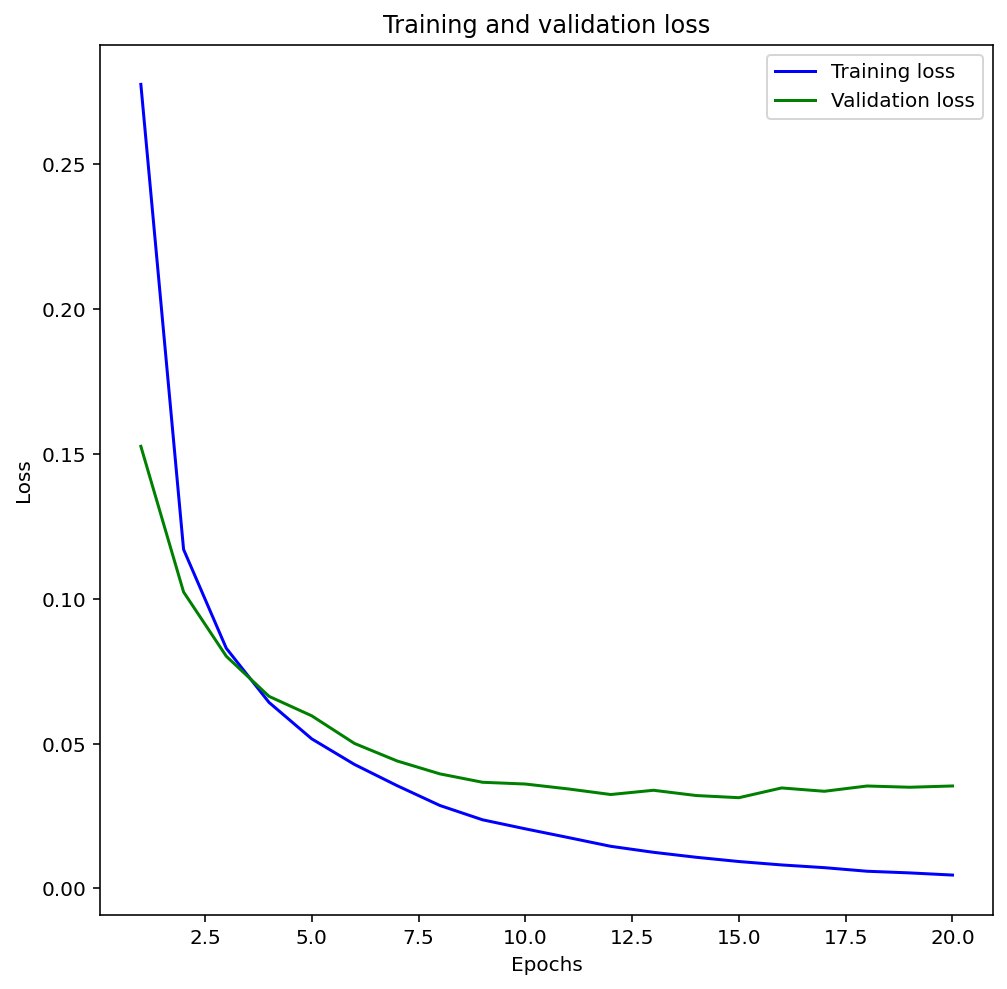

In [36]:
plt.figure(figsize=(8,8))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

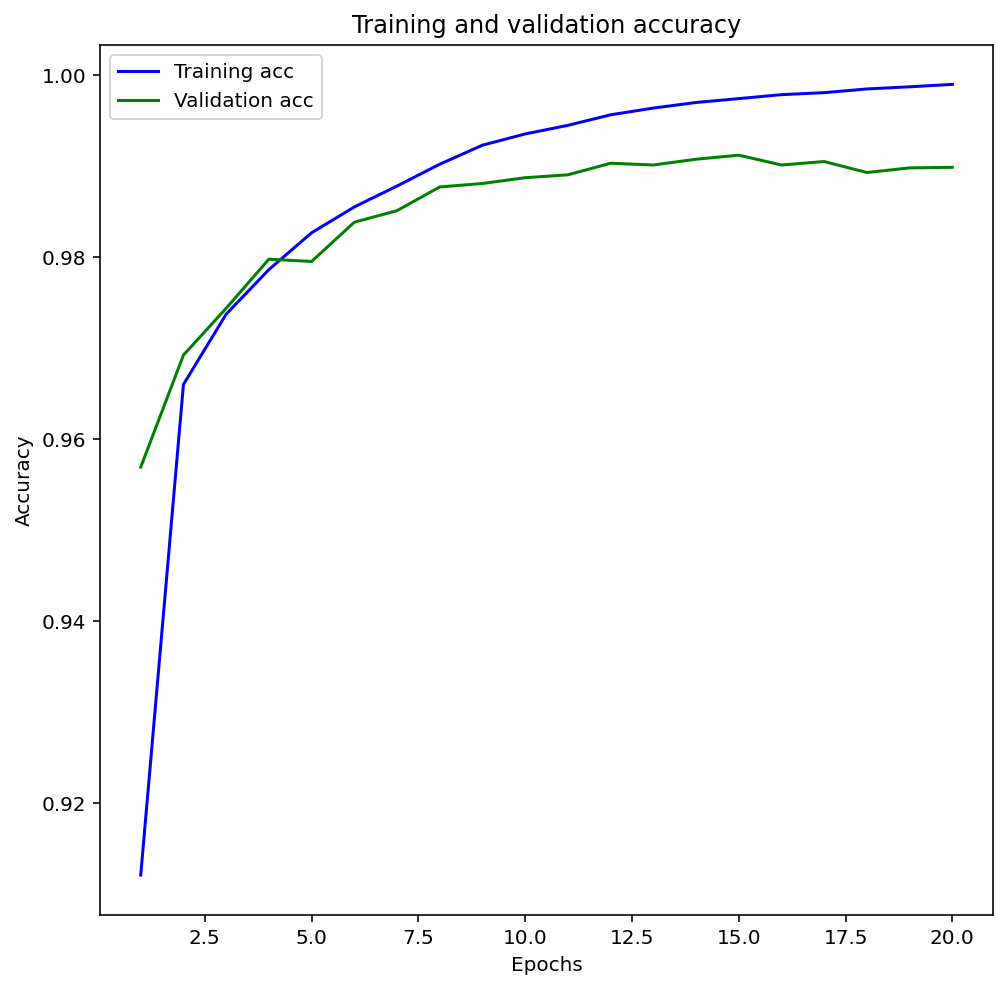

In [37]:
plt.figure(figsize=(8,8))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

---

## Evaluate the model

### Compute f-score on the test set

In [38]:
test_sequences = [doc_tokens_to_sequence(reuters_corpus.get_tokens(doc_id), word_to_idx_map) for doc_id in test_doc_ids]
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_doc_len)

In [39]:
test_pred = nn_model.predict(test_padded_sequences)

In [40]:
# round to nearest integer
test_pred = np.rint(test_pred)

In [41]:
test_pred[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [42]:
from sklearn.metrics import classification_report

In [43]:
print(classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       497
           1       0.68      0.62      0.65        24
           2       1.00      0.76      0.86        25
           3       0.78      0.75      0.76        52
           4       0.89      0.89      0.89       114
           5       0.93      0.74      0.82        38
           6       0.99      0.98      0.99       778
           7       0.74      0.74      0.74        23
           8       0.89      1.00      0.94        24
           9       0.93      0.89      0.91       110
          10       0.89      0.88      0.88        99
          11       0.92      0.83      0.87       145
          12       0.92      0.85      0.88        39
          13       0.65      0.57      0.61        35
          14       0.88      0.83      0.85        64
          15       0.85      0.44      0.58        25
          16       0.92      0.61      0.73        36
          17       0.96    

/home/nvidia/anaconda3/envs/testenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Save model to a file

In [44]:
nn_filename = 'reuters_nn_model.h5'
nn_filepath = os.path.join(root_dir, models_dir, nn_filename)

In [45]:
nn_model.save(nn_filepath)

---

## Save `word_to_index_map` to a file

In [46]:
import pandas as pd

In [47]:
word_to_index_df = pd.DataFrame(word_to_idx_map.items(), columns=['term', 'index'])

In [48]:
word_to_index_df.head()

,term,index
0,",100",1
1,-aci,2
2,-agency,3
3,-analysts,4
4,-announced,5


In [49]:
word_to_index_df.shape

(38016, 2)

In [50]:
index_filename = 'reuters_nn_word_index.csv'
index_filepath = os.path.join(root_dir, models_dir, index_filename)

In [51]:
word_to_index_df.to_csv(index_filepath, encoding='utf-8', index=False)

---